### Objective
The objective of this project is to analyse factors influencing survival in road accidents and develop a predictive model that estimates the probability of survival. By leveraging demographic, behavioral, and situational data, the analysis aims to identify key contributors to survival rates and provide insights for improving road safety measures.

### Purpose
- To understand the impact of various factors (age, gender, speed of impact, safety device usage, etc.) on survival outcomes.
- To develop a machine learning model that predicts survival probability based on accident-related data.
- To generate actionable insights that can help policymakers, emergency responders, and vehicle manufacturers enhance road safety strategies.

In [40]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import RFE
import xgboost as XGBoost

In [3]:
# load the Dataset
data = pd.read_csv('accident.csv')
data

,Age,Gender,Speed_of_Impact,Helmet_Used,Seatbelt_Used,Survived
0,56,Female,27.0,No,No,1
1,69,Female,46.0,No,Yes,1
2,46,Male,46.0,Yes,Yes,0
3,32,Male,117.0,No,Yes,0
4,60,Female,40.0,Yes,Yes,0
...,...,...,...,...,...,...
195,69,Female,111.0,No,Yes,1
196,30,Female,51.0,No,Yes,1
197,58,Male,110.0,No,Yes,1
198,20,Male,103.0,No,Yes,1


In [4]:
# Understand the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              200 non-null    int64  
 1   Gender           199 non-null    object 
 2   Speed_of_Impact  197 non-null    float64
 3   Helmet_Used      200 non-null    object 
 4   Seatbelt_Used    200 non-null    object 
 5   Survived         200 non-null    int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 9.5+ KB


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,200.0,43.425000,14.941910,18.0,31.0,43.5,56.0,69.0
Speed_of_Impact,197.0,70.441624,30.125298,20.0,43.0,71.0,95.0,119.0
Survived,200.0,0.505000,0.501230,0.0,0.0,1.0,1.0,1.0


In [6]:
data.describe(include = 'object').T

,count,unique,top,freq
Gender,199,2,Female,110
Helmet_Used,200,2,Yes,111
Seatbelt_Used,200,2,Yes,111


In [7]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())

# Handle missing values
# For Gender, fill with the most common value
data['Gender'].fillna(data['Gender'].mode()[0], inplace=True)

# For Speed_of_Impact, fill with the median
data['Speed_of_Impact'].fillna(data['Speed_of_Impact'].median(), inplace=True)

Missing values per column:
Age                0
Gender             1
Speed_of_Impact    3
Helmet_Used        0
Seatbelt_Used      0
Survived           0
dtype: int64


In [8]:
# Basic statistics
print("\nBasic statistics of numerical features:")
data.describe().round(2)


Basic statistics of numerical features:


,Age,Speed_of_Impact,Survived
count,200.00,200.00,200.0
mean,43.42,70.45,0.5
std,14.94,29.90,0.5
min,18.00,20.00,0.0
25%,31.00,43.00,0.0
50%,43.50,71.00,1.0
75%,56.00,95.00,1.0
max,69.00,119.00,1.0


#### Data Visualization and Feature Analysis

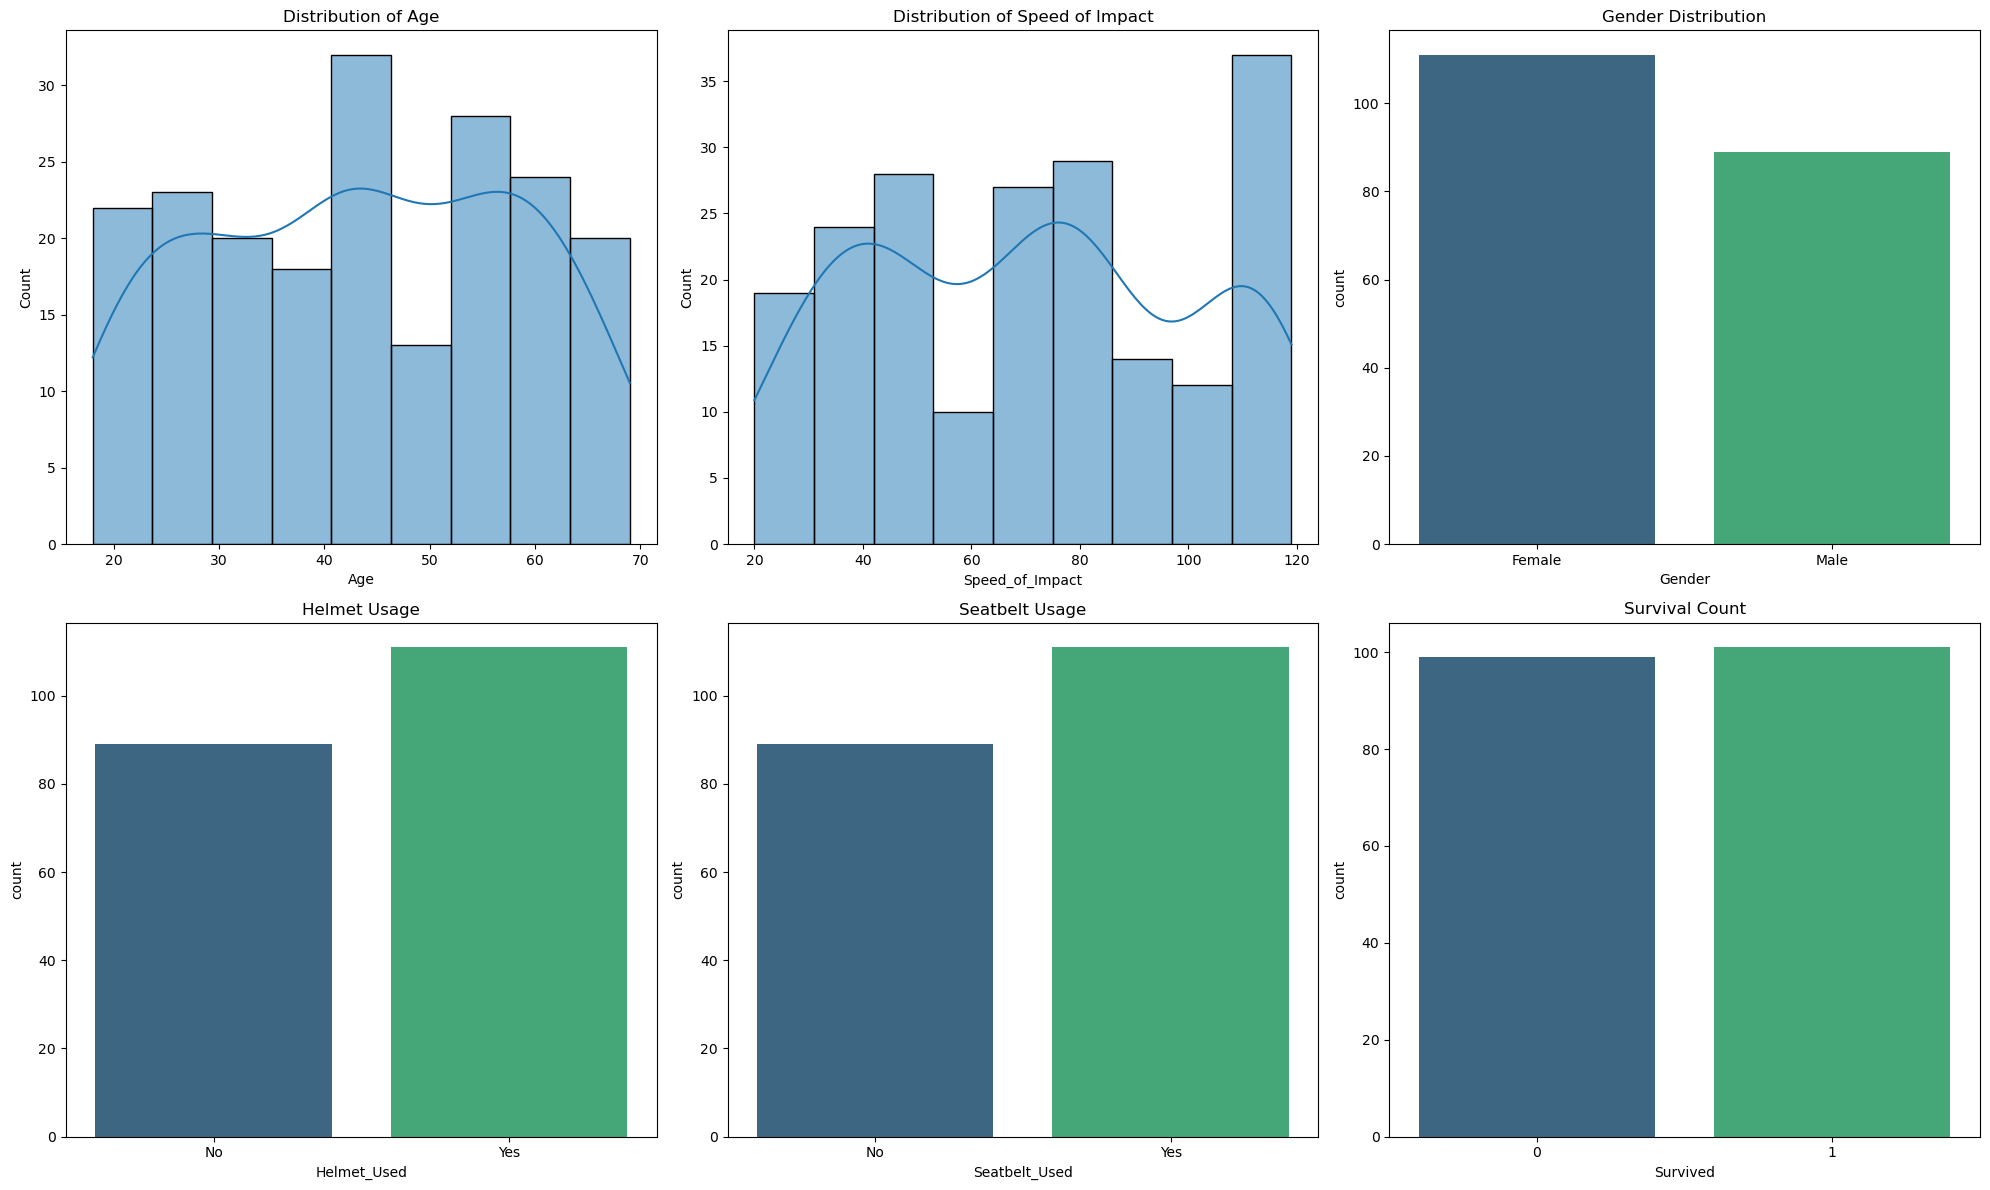

In [10]:
# Define the columns and their types (histplot or countplot)
plots = [
    ('Age', 'histplot', 'Distribution of Age'),
    ('Speed_of_Impact', 'histplot', 'Distribution of Speed of Impact'),
    ('Gender', 'countplot', 'Gender Distribution'),
    ('Helmet_Used', 'countplot', 'Helmet Usage'),
    ('Seatbelt_Used', 'countplot', 'Seatbelt Usage'),
    ('Survived', 'countplot', 'Survival Count')
]

plt.figure(figsize=(20, 12))

# Loop through the plots list and create subplots dynamically
for i, (col, plot_type, title) in enumerate(plots, 1):
    plt.subplot(2, 3, i)  # Adjust subplot layout
    
    if plot_type == 'histplot':
        sns.histplot(data[col], kde=True)
    else:  # countplot
        sns.countplot(x=col, data=data, palette='viridis')
    
    plt.title(title)

plt.tight_layout()
plt.show()


#### Relationship Between Features and Survival

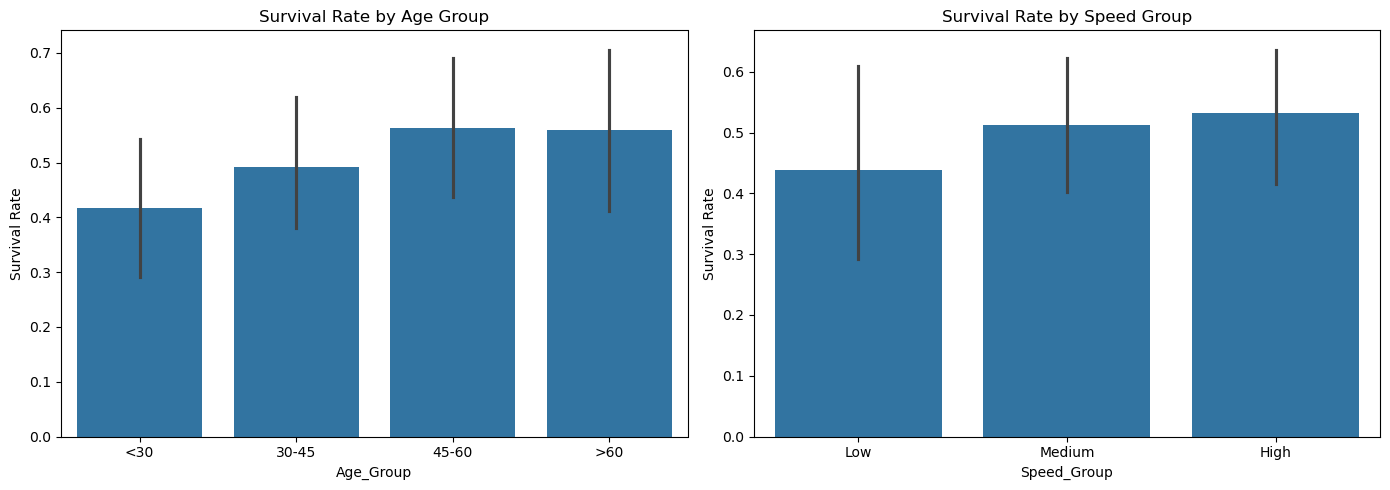

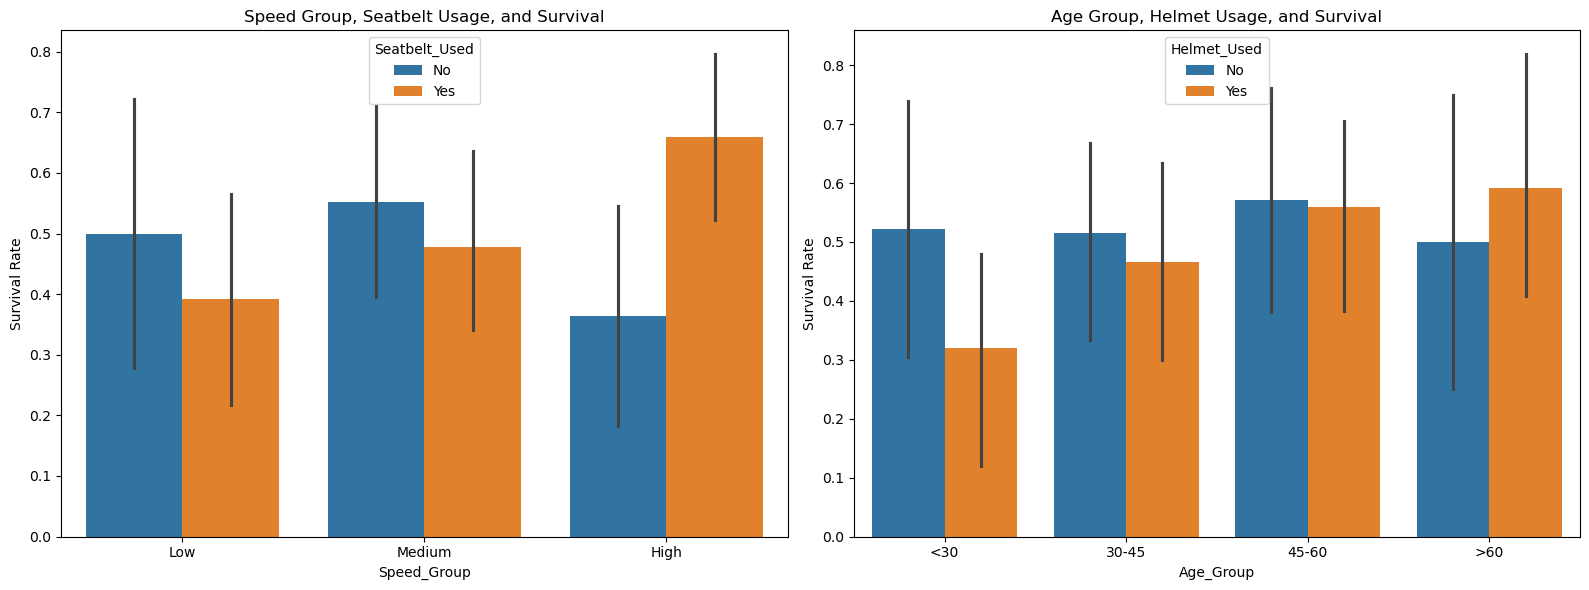

In [12]:
# Create age and speed groups
data['Age_Group'] = pd.cut(data['Age'], bins=[0, 30, 45, 60, 100], labels=['<30', '30-45', '45-60', '>60'])
data['Speed_Group'] = pd.cut(data['Speed_of_Impact'], bins=[0, 40, 80, 120], labels=['Low', 'Medium', 'High'])

# Define plot settings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Define variables for looping
survival_plots = [
    ('Age_Group', 'Survival Rate by Age Group', axes[0]),
    ('Speed_Group', 'Survival Rate by Speed Group', axes[1])
]

# Create survival rate plots
for col, title, ax in survival_plots:
    sns.barplot(x=col, y='Survived', data=data, estimator=np.mean, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('Survival Rate')

plt.tight_layout()
plt.show()

# Define plot settings for safety equipment effectiveness
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define variables for looping
safety_plots = [
    ('Speed_Group', 'Seatbelt_Used', 'Speed Group, Seatbelt Usage, and Survival', axes[0]),
    ('Age_Group', 'Helmet_Used', 'Age Group, Helmet Usage, and Survival', axes[1])
]

# Create safety equipment effectiveness plots
for x_col, hue_col, title, ax in safety_plots:
    sns.barplot(x=x_col, y='Survived', hue=hue_col, data=data, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel('Survival Rate')

plt.tight_layout()
plt.show()


### Feature Engineering
- Based on our exploratory analysis, we'll create new features that might better capture the relationships we've observed:

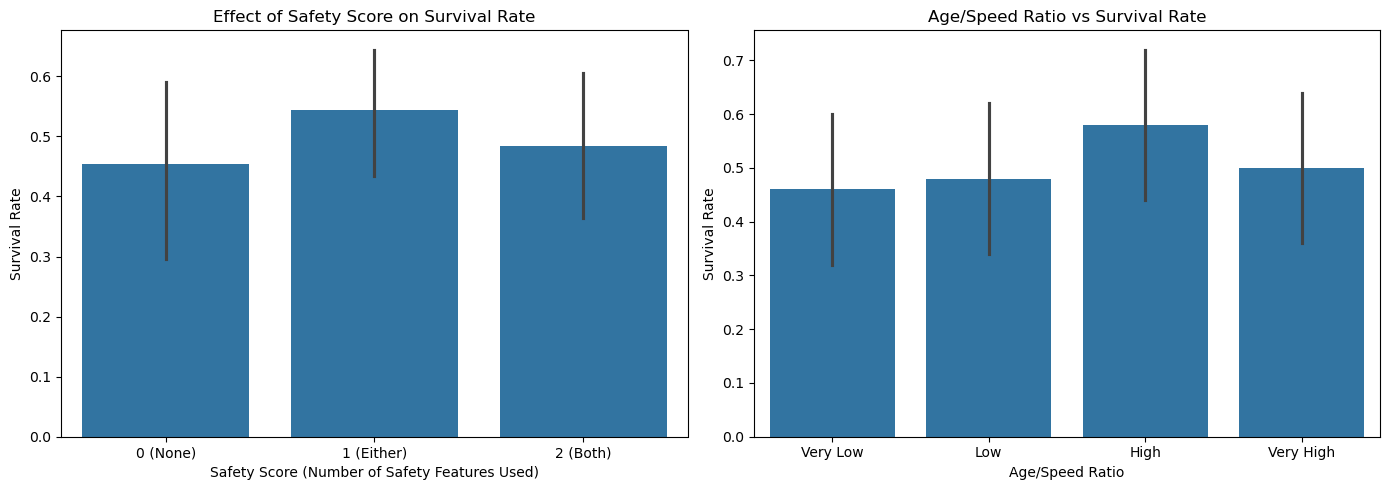

In [36]:
# Create new interaction features
# Combine Age and Speed
data['Age_Speed_Ratio'] = data['Age'] / data['Speed_of_Impact']

# Create safety score (0, 1, or 2 safety features used)
data['Safety_Score'] = (data['Helmet_Used'] == 'Yes').astype(int) + (data['Seatbelt_Used'] == 'Yes').astype(int)

# Let's visualize the effect of these new features
plt.figure(figsize=(14, 5))

# Effect of safety score on survival
plt.subplot(1, 2, 1)
sns.barplot(x='Safety_Score', y='Survived', data=data)
plt.title('Effect of Safety Score on Survival Rate')
plt.xlabel('Safety Score (Number of Safety Features Used)')
plt.ylabel('Survival Rate')
plt.xticks([0, 1, 2], ['0 (None)', '1 (Either)', '2 (Both)'])

# Relationship between Age/Speed Ratio and Survival
plt.subplot(1, 2, 2)
# Create bins for the Age/Speed Ratio
data['Age_Speed_Ratio_Bin'] = pd.qcut(data['Age_Speed_Ratio'], 4, labels=['Very Low', 'Low', 'High', 'Very High'])
sns.barplot(x='Age_Speed_Ratio_Bin', y='Survived', data=data)
plt.title('Age/Speed Ratio vs Survival Rate')
plt.xlabel('Age/Speed Ratio')
plt.ylabel('Survival Rate')

plt.tight_layout()
plt.show()

#### Predictive Modeling
- Data Preparation for Modeling

In [42]:
# Prepare data for modeling
# One-hot encode categorical variables
data_model = pd.get_dummies(data, columns=['Gender', 'Helmet_Used', 'Seatbelt_Used'], drop_first=True)

# Define features and target
X = data_model[['Age', 'Speed_of_Impact', 'Gender_Male', 'Helmet_Used_Yes', 
              'Seatbelt_Used_Yes', 'Age_Speed_Ratio', 'Safety_Score']]
y = data_model['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Logistic Regression - Accuracy: 0.6167, AUC: 0.6195
Random Forest - Accuracy: 0.4333, AUC: 0.4590
Gradient Boosting - Accuracy: 0.5000, AUC: 0.5572
XGBoost - Accuracy: 0.4833, AUC: 0.5679


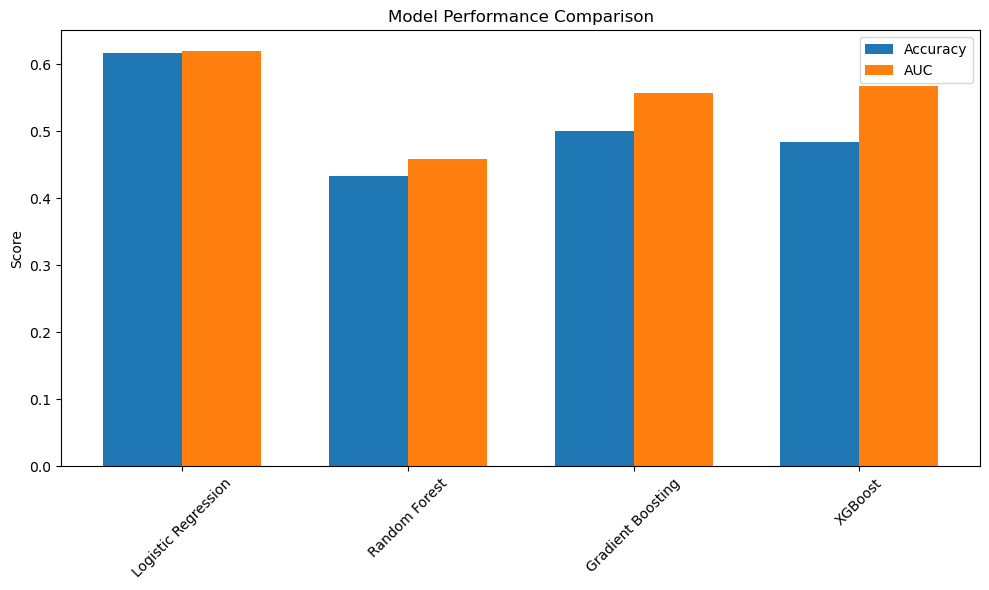

In [44]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBoost.XGBClassifier(random_state=42)
}

# Fit all models and collect results
results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy and AUC
    accuracy = accuracy_score(y_test, y_pred)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'auc': auc,
        'model': model
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

# Visualize model performance
plt.figure(figsize=(10, 6))
accuracies = [results[name]['accuracy'] for name in models.keys()]
aucs = [results[name]['auc'] for name in models.keys()]

x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, accuracies, width, label='Accuracy')
plt.bar(x + width/2, aucs, width, label='AUC')
plt.xticks(x, models.keys(), rotation=45)
plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Examine the coefficients of our best model (Logistic Regression)
best_model = results['Logistic Regression']['model']
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_model.coef_[0]
})
coefficients = coefficients.sort_values('Coefficient', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Logistic Regression Coefficients')
plt.axvline(x=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

# Hyperparameter tuning with GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(random_state=42),
    {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2']
    },
    cv=5,
    scoring='roc_auc'
)

grid_search.fit(X, y)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation AUC: {grid_search.best_score_:.4f}")

# Final model
final_model = LogisticRegression(**grid_search.best_params_, random_state=42)
final_model.fit(X, y)


In [49]:
def predict_survival(age, gender, speed, helmet, seatbelt):
    """
    Predicts the probability of survival in a road accident.
    
    Parameters:
    age (int): Age of the person
    gender (str): 'Male' or 'Female'
    speed (float): Speed of impact
    helmet (str): 'Yes' or 'No' if helmet was used
    seatbelt (str): 'Yes' or 'No' if seatbelt was used
    
    Returns:
    float: Probability of survival (0-1)
    """
    # Convert inputs to model features
    gender_male = 1 if gender == 'Male' else 0
    helmet_yes = 1 if helmet == 'Yes' else 0
    seatbelt_yes = 1 if seatbelt == 'Yes' else 0
    
    # Calculate derived features
    age_speed_ratio = age / speed if speed > 0 else 0
    safety_score = helmet_yes + seatbelt_yes
    
    # Create feature vector
    features = np.array([[age, speed, gender_male, helmet_yes, seatbelt_yes, 
                          age_speed_ratio, safety_score]])
    
    # Predict probability
    return final_model.predict_proba(features)[0][1]

# Visualize survival probabilities across different scenarios
ages = range(20, 70, 10)
speeds = range(20, 120, 20)

# For Males with both safety measures
male_both_probs = np.zeros((len(ages), len(speeds)))
for i, age in enumerate(ages):
    for j, speed in enumerate(speeds):
        male_both_probs[i, j] = predict_survival(age, 'Male', speed, 'Yes', 'Yes')

# For Females with both safety measures
female_both_probs = np.zeros((len(ages), len(speeds)))
for i, age in enumerate(ages):
    for j, speed in enumerate(speeds):
        female_both_probs[i, j] = predict_survival(age, 'Female', speed, 'Yes', 'Yes')

# Plot line graphs
fig, ax = plt.subplots(figsize=(10, 6))
for i, age in enumerate(ages):
    plt.plot(speeds, male_both_probs[i, :], marker='o', linestyle='-', label=f'Male Age {age}')
    plt.plot(speeds, female_both_probs[i, :], marker='s', linestyle='--', label=f'Female Age {age}')

plt.xlabel('Speed of Impact (km/h)')
plt.ylabel('Survival Probability')
plt.title('Survival Probability Across Ages and Speeds')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'final_model' is not defined